In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K

2023-12-14 06:46:54.096269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 06:46:55.161504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import tensorflow as tf
import os
import shutil
import random
import pandas as pd

# 定义文件夹路径
dataset_path = "Rice_Image_Dataset"  # 替换成您的数据集路径
dataset_name = "Rice_Image_Dataset"  # 数据集名称
# 定义类别和比例
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# 创建训练集、验证集和测试集文件夹
os.makedirs(os.path.join(dataset_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'test'), exist_ok=True)

In [4]:
# Creating subfolders for each category in the train and test folders
for PlantVillage in classes:
    os.makedirs(os.path.join(dataset_path, 'train', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'test', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'val', PlantVillage), exist_ok=True)

In [5]:
# 创建一个空的 DataFrame
df = pd.DataFrame(columns=['class', 'trainset', 'testset','valset'])

print('{:^18} {:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数','验证集数据个数'))

for rice in classes: # 遍历每个类别
    dataset_path2 = "Rice_Image_Dataset" 
    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, rice)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_number = int(len(images_filename) * test_frac) 
    valset_number = int(len(images_filename) * val_frac)
    train_number = int(len(images_filename) * train_frac)


    testset_images = images_filename[:testset_number]
    valset_images = images_filename[testset_number:testset_number + valset_number]
    trainset_images = images_filename[testset_number + valset_number: testset_number + valset_number + train_number]


    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, rice, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'test', rice, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    # 移动图像至 val 目录
    for image in valset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_val_path = os.path.join(dataset_path, 'val', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_val_path) # 移动文件
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18} {:^18}'.format(rice, len(trainset_images), len(testset_images),len(valset_images)))
    
    # 保存到表格中
    df = pd.concat([
    df,
    pd.DataFrame({
        'class': [rice],
        'trainset': [len(trainset_images)],
        'testset': [len(testset_images)],
        'valset': [len(valset_images)]
      })
], ignore_index=True)

# 重命名数据集文件夹
shutil.move(dataset_path, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset'] + df['valset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数            验证集数据个数      
     Arborio             10500               2250               2250       
     Basmati             10500               2250               2250       
      Ipsala             10500               2250               2250       
     Jasmine             10500               2250               2250       
    Karacadag            10500               2250               2250       


In [6]:
df

,class,trainset,testset,valset,total
0,Arborio,10500,2250,2250,15000
1,Basmati,10500,2250,2250,15000
2,Ipsala,10500,2250,2250,15000
3,Jasmine,10500,2250,2250,15000
4,Karacadag,10500,2250,2250,15000


In [7]:
dataset_dir = 'Rice_Image_Dataset_split'

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Specify the validation split here
    fill_mode='nearest'
)

In [10]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

Found 42000 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [12]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, multiply, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]  # 获取输入特征图的通道数
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

# 创建带有SE模块的卷积神经网络模型
input_shape = (128, 128, 3)
inputs = tf.keras.Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = se_block(x)  # 添加SE模块
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = se_block(x)  # 添加SE模块
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = se_block(x)  # 添加SE模块
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs1 = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs1)
# Compile model with specific learning rate

# 打印模型摘要
model.summary()
# Compile the model
import keras.backend as K

# 自定义损失函数
def custom_categorical_crossentropy(y_true, y_pred):
    # 定义自定义的分类交叉熵损失函数
    epsilon = 1e-9  # 添加一个很小的数值以避免log(0)情况
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)  # 将预测值限制在一个较小的范围内，避免log(0)情况
    loss = -K.mean(y_true * K.log(y_pred))  # 计算损失
    return loss
def custom_accuracy(y_true, y_pred):
    predicted_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    
    # Check equality between predicted and true labels and calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, true_labels), tf.float32))
    return accuracy
opt = Adam(learning_rate=0.0001)
# 使用自定义损失函数编译模型
model.compile(optimizer=opt, loss=custom_categorical_crossentropy, metrics=custom_accuracy)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 126, 126, 32)         896       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 global_average_pooling2d_6  (None, 32)                   0         ['max_pooling2d_6[0][0]'

In [18]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator,verbose=2)

Epoch 1/30
2625/2625 - 156s - loss: 0.0089 - custom_accuracy: 0.9859 - val_loss: 0.0031 - val_custom_accuracy: 0.9949 - 156s/epoch - 59ms/step
Epoch 2/30
2625/2625 - 143s - loss: 0.0096 - custom_accuracy: 0.9849 - val_loss: 0.0032 - val_custom_accuracy: 0.9945 - 143s/epoch - 54ms/step
Epoch 3/30
2625/2625 - 153s - loss: 0.0089 - custom_accuracy: 0.9856 - val_loss: 0.0016 - val_custom_accuracy: 0.9973 - 153s/epoch - 58ms/step
Epoch 4/30
2625/2625 - 146s - loss: 0.0088 - custom_accuracy: 0.9855 - val_loss: 0.0024 - val_custom_accuracy: 0.9959 - 146s/epoch - 56ms/step
Epoch 5/30
2625/2625 - 158s - loss: 0.0081 - custom_accuracy: 0.9867 - val_loss: 0.0112 - val_custom_accuracy: 0.9777 - 158s/epoch - 60ms/step
Epoch 6/30
2625/2625 - 155s - loss: 0.0077 - custom_accuracy: 0.9880 - val_loss: 0.0032 - val_custom_accuracy: 0.9943 - 155s/epoch - 59ms/step
Epoch 7/30
2625/2625 - 148s - loss: 0.0076 - custom_accuracy: 0.9878 - val_loss: 0.0020 - val_custom_accuracy: 0.9961 - 148s/epoch - 56ms/step

In [19]:
test_loss_ensemble, test_acc_ensemble = model.evaluate(test_generator)

704/704 [==============================] - 9s 12ms/step - loss: 0.0039 - custom_accuracy: 0.9933


In [20]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [22]:
from tensorflow.keras.optimizers import Adam
def attention_block(input_tensor):
    # 定义注意力机制块
    channels = input_tensor.shape[-1]  # 获取输入特征图的通道数

    # 注意力机制
    attention_probs = GlobalAveragePooling2D()(input_tensor)
    attention_probs = Dense(channels // 2, activation='relu')(attention_probs)
    attention_probs = Dense(channels, activation='sigmoid')(attention_probs)
    attention_probs = Reshape((1, 1, channels))(attention_probs)
    attention_mul = multiply([input_tensor, attention_probs])

    return attention_mul

# 图像尺寸和通道数
height = 128
width = 128
channels = 3  # 24位深度通常指RGB图像

input_shape = (height, width, channels)
num_classes = 5  # 数据集的类别数

inputs = Input(shape=input_shape)

conv_1 = Conv2D(32, (3, 3), activation='relu')(inputs)
conv_2 = Conv2D(64, (3, 3), activation='relu')(conv_1)
maxpool_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)

# 添加注意力机制块
attention_block_1 = attention_block(maxpool_1)

conv_3 = Conv2D(128, (3, 3), activation='relu')(attention_block_1)
maxpool_2 = MaxPooling2D(pool_size=(2, 2))(conv_3)

# 添加注意力机制块
attention_block_2 = attention_block(maxpool_2)

flatten = Flatten()(attention_block_2)
dense_1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.5)(dense_1)
outputs2 = Dense(5, activation='softmax')(dropout_1)

# 定义模型
model_1 = Model(inputs=inputs, outputs=outputs2)


# 打印模型摘要
model_1.summary()
# Compile the model
import keras.backend as K

# 自定义损失函数
def custom_categorical_crossentropy(y_true, y_pred):
    # 定义自定义的分类交叉熵损失函数
    epsilon = 1e-9  # 添加一个很小的数值以避免log(0)情况
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)  # 将预测值限制在一个较小的范围内，避免log(0)情况
    loss = -K.mean(y_true * K.log(y_pred))  # 计算损失
    return loss
def custom_accuracy(y_true, y_pred):
    predicted_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    
    # Check equality between predicted and true labels and calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, true_labels), tf.float32))
    return accuracy
opt = Adam(learning_rate=0.0001)
# 使用自定义损失函数编译模型
model_1.compile(optimizer=opt, loss=custom_categorical_crossentropy, metrics=custom_accuracy)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 126, 126, 32)         896       ['input_5[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 124, 124, 64)         18496     ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 64)           0         ['conv2d_13[0][0]']           
 ng2D)                                                                                      

In [23]:
history = model_1.fit(train_generator, epochs=30, validation_data=validation_generator,verbose=2)

Epoch 1/30
2625/2625 - 147s - loss: 0.1220 - custom_accuracy: 0.7524 - val_loss: 0.0629 - val_custom_accuracy: 0.8865 - 147s/epoch - 56ms/step
Epoch 2/30
2625/2625 - 151s - loss: 0.0561 - custom_accuracy: 0.8971 - val_loss: 0.0666 - val_custom_accuracy: 0.8627 - 151s/epoch - 58ms/step
Epoch 3/30
2625/2625 - 155s - loss: 0.0394 - custom_accuracy: 0.9305 - val_loss: 0.0368 - val_custom_accuracy: 0.9322 - 155s/epoch - 59ms/step
Epoch 4/30
2625/2625 - 158s - loss: 0.0290 - custom_accuracy: 0.9505 - val_loss: 0.0575 - val_custom_accuracy: 0.8887 - 158s/epoch - 60ms/step
Epoch 5/30
2625/2625 - 155s - loss: 0.0242 - custom_accuracy: 0.9583 - val_loss: 0.0191 - val_custom_accuracy: 0.9636 - 155s/epoch - 59ms/step
Epoch 6/30
2625/2625 - 153s - loss: 0.0225 - custom_accuracy: 0.9626 - val_loss: 0.0299 - val_custom_accuracy: 0.9465 - 153s/epoch - 58ms/step
Epoch 7/30
2625/2625 - 147s - loss: 0.0213 - custom_accuracy: 0.9645 - val_loss: 0.0245 - val_custom_accuracy: 0.9537 - 147s/epoch - 56ms/step

In [24]:
test_loss_ensemble, test_acc_ensemble = model_1.evaluate(test_generator)

704/704 [==============================] - 11s 15ms/step - loss: 0.0027 - custom_accuracy: 0.9953


In [25]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()
x_val,y_val = validation_generator.next()

In [29]:
from tensorflow.keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, multiply, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-9
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -K.mean(y_true * K.log(y_pred))
    return loss

def custom_accuracy(y_true, y_pred):
    predicted_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, true_labels), tf.float32))
    return accuracy
# 第一个模型
def first_model(input_shape=(128, 128, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = se_block(x)  # 添加SE模块
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = se_block(x)  # 添加SE模块
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = se_block(x)  # 添加SE模块
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=custom_categorical_crossentropy, metrics=custom_accuracy)
    
    return model

# 第二个模型
def second_model(input_shape=(128, 128, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    conv_1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    conv_2 = Conv2D(64, (3, 3), activation='relu')(conv_1)
    maxpool_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    
    attention_block_1 = attention_block(maxpool_1)
    
    conv_3 = Conv2D(128, (3, 3), activation='relu')(attention_block_1)
    maxpool_2 = MaxPooling2D(pool_size=(2, 2))(conv_3)
    
    attention_block_2 = attention_block(maxpool_2)
    
    flatten = Flatten()(attention_block_2)
    dense_1 = Dense(256, activation='relu')(flatten)
    dropout_1 = Dropout(0.5)(dense_1)
    outputs = Dense(5, activation='softmax')(dropout_1)
    
    model_1 = Model(inputs=inputs, outputs=outputs)
    
    opt = Adam(learning_rate=0.0001)
    model_1.compile(optimizer=opt, loss=custom_categorical_crossentropy, metrics=custom_accuracy)
    return model_1

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, Flatten, Lambda
from tensorflow.keras.optimizers import Adam

# Assuming you have defined 'first_model()' and 'second_model()' somewhere

# Instantiate two models
model = first_model()
model_1 = second_model()

# Specify input shape
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Obtain outputs from the first and second models
output_1 = model(inputs)
output_2 = model_1(inputs)

# Concatenate the outputs
merged_outputs = concatenate([output_1, output_2])
# Add layers as needed
x = Dense(100, activation='relu')(merged_outputs)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# Define the final ensemble output layer (assuming 5 classes for softmax)
ensemble_output = Dense(5, activation='softmax')(x)

# Define custom loss and accuracy functions
def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-9
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    # Compute cross-entropy without multiplying by y_true (it's not broadcastable)
    loss = -tf.reduce_mean(y_true * tf.math.log(y_pred), axis=-1)
    return loss


def custom_accuracy(y_true, y_pred):
    predicted_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, true_labels), tf.float32))
    return accuracy

opt = Adam(learning_rate=0.0001)

# Create the ensemble model
ensemble_model = Model(inputs=inputs, outputs=ensemble_output)

# Compile the model
ensemble_model.compile(optimizer=opt, loss=custom_categorical_crossentropy, metrics=[custom_accuracy])

# Display the model summary
ensemble_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_8 (Functional)        (None, 5)                    1307435   ['input_11[0][0]']            
                                                          5                                       
                                                                                                  
 model_9 (Functional)        (None, 5)                    2960675   ['input_11[0][0]']            
                                                          7                                       
                                                                                           

In [31]:
# Assuming 'train_generator' and 'validation_generator' are defined for training/validation data
history = ensemble_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=2)

Epoch 1/30
2625/2625 - 154s - loss: 0.2303 - custom_accuracy: 0.4912 - val_loss: 0.1978 - val_custom_accuracy: 0.5512 - 154s/epoch - 59ms/step
Epoch 2/30
2625/2625 - 154s - loss: 0.1219 - custom_accuracy: 0.7580 - val_loss: 0.1200 - val_custom_accuracy: 0.7414 - 154s/epoch - 59ms/step
Epoch 3/30
2625/2625 - 149s - loss: 0.0798 - custom_accuracy: 0.8675 - val_loss: 0.1428 - val_custom_accuracy: 0.7159 - 149s/epoch - 57ms/step
Epoch 4/30
2625/2625 - 148s - loss: 0.0547 - custom_accuracy: 0.9205 - val_loss: 0.0562 - val_custom_accuracy: 0.9113 - 148s/epoch - 56ms/step
Epoch 5/30
2625/2625 - 148s - loss: 0.0444 - custom_accuracy: 0.9387 - val_loss: 0.1275 - val_custom_accuracy: 0.8091 - 148s/epoch - 56ms/step
Epoch 6/30
2625/2625 - 143s - loss: 0.0373 - custom_accuracy: 0.9496 - val_loss: 0.0883 - val_custom_accuracy: 0.8781 - 143s/epoch - 55ms/step
Epoch 7/30
2625/2625 - 145s - loss: 0.0334 - custom_accuracy: 0.9552 - val_loss: 0.0177 - val_custom_accuracy: 0.9735 - 145s/epoch - 55ms/step

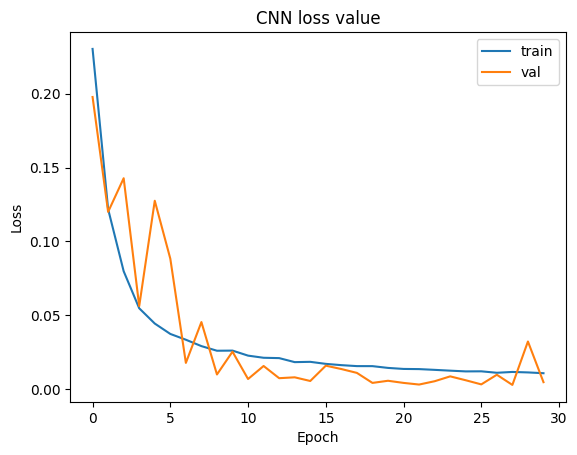

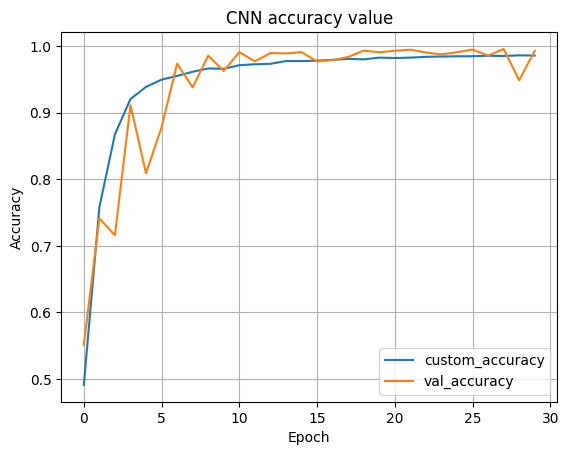

In [32]:
import matplotlib.pyplot as plt
# 绘制loss图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("CNN loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)



# 绘制准确率
plt.plot(history.history['custom_accuracy'], label='custom_accuracy')
plt.plot(history.history['val_custom_accuracy'], label='val_accuracy')
plt.title("CNN accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print("Test accuracy:", test_acc)

704/704 [==============================] - 9s 13ms/step - loss: 0.0056 - custom_accuracy: 0.9920
Test accuracy: 0.9920099377632141


704/704 [==============================] - 8s 11ms/step


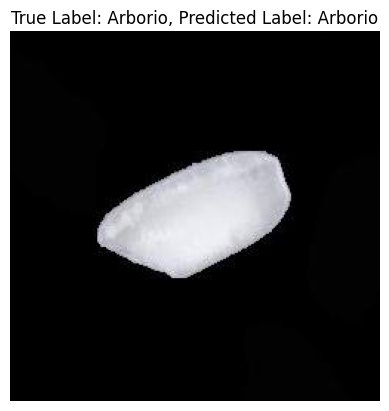

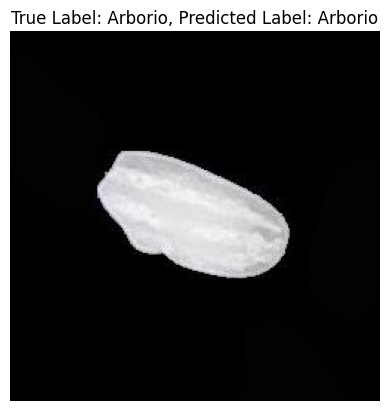

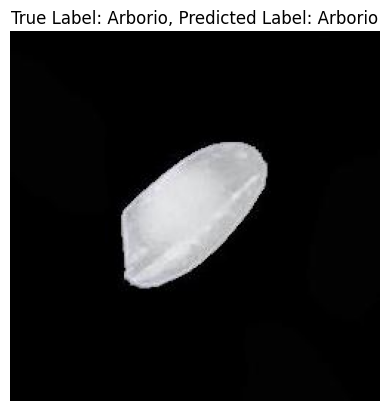

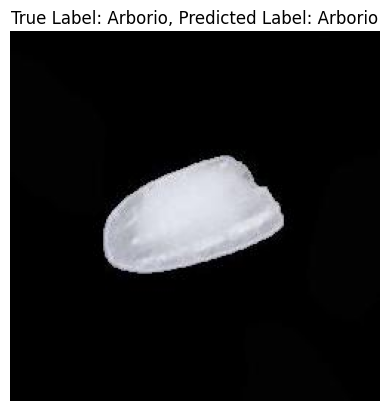

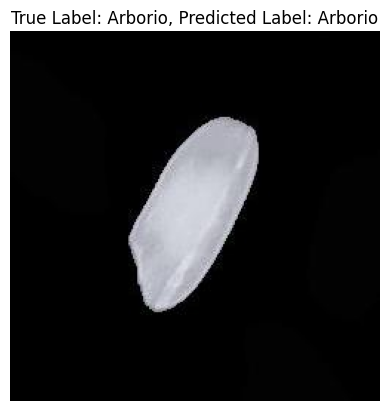

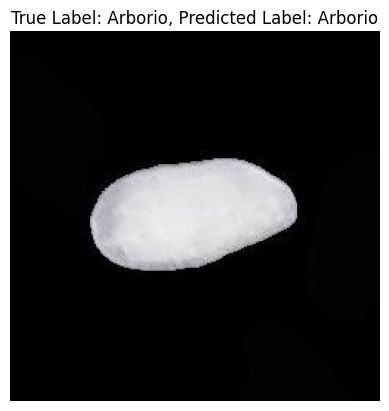

In [34]:
import numpy as np

predictions = ensemble_model.predict(test_generator)
from tensorflow.keras.preprocessing import image
# Retrieve the true class labels
true_labels = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Display the first few images with true and predicted labels
for i in range(6):  # Display the first 5 images (you can change this number)
    plt.figure()
    plt.imshow(image.load_img(os.path.join(test_dir, test_generator.filenames[i])))
    plt.title(f"True Label: {class_labels[true_labels[i]]}, Predicted Label: {class_labels[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.show()

704/704 [==============================] - 9s 12ms/step


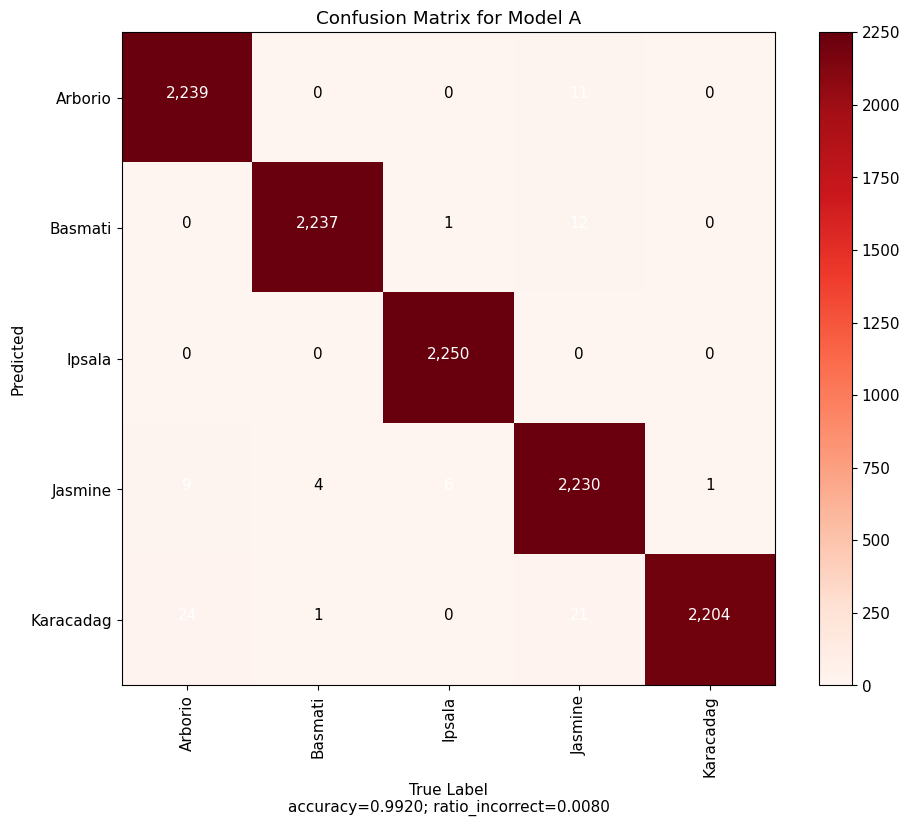

In [35]:
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(validation_generator, ensemble_model, test_generator, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = validation_generator.classes
    
    plot_labels = np.array([i for i in validation_generator.class_indices.keys()])
    
    cm = confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm) / np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    # plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

# 使用方式：
plot_confusion_matrix(validation_generator, ensemble_model, test_generator, 'Model A')

704/704 [==============================] - 10s 15ms/step


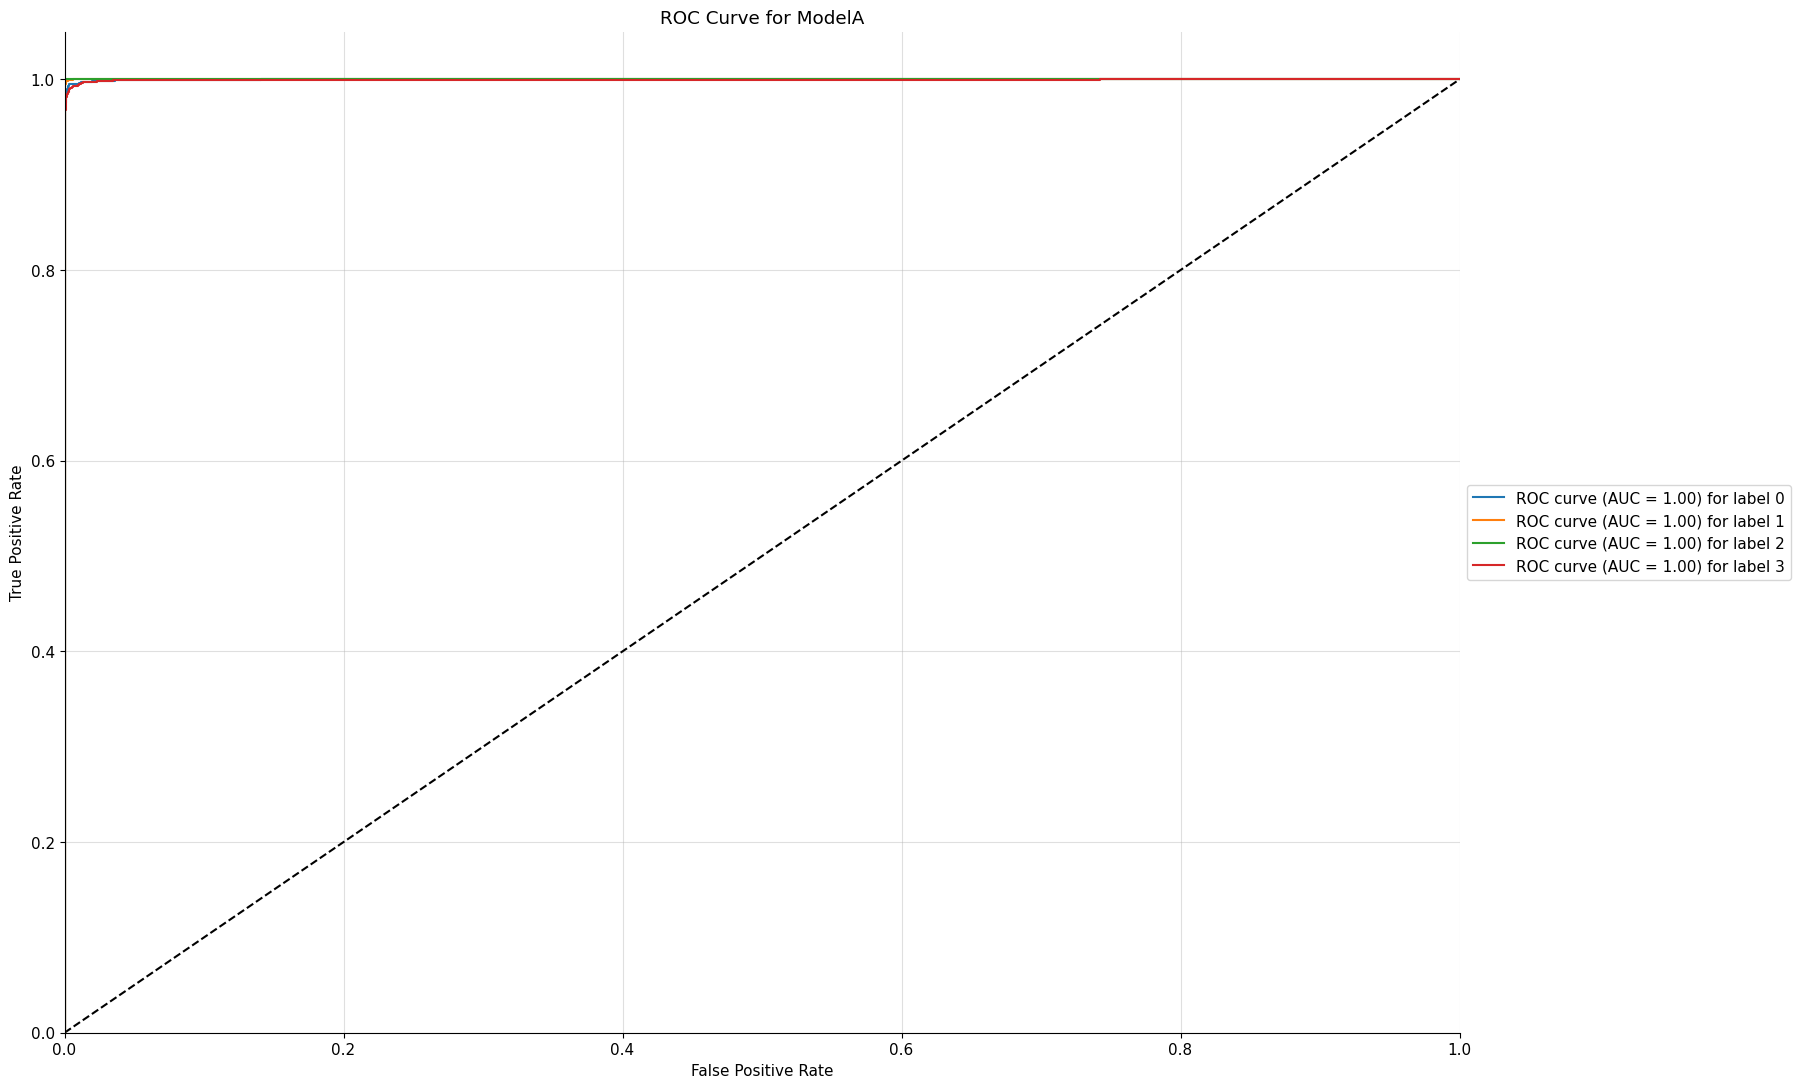

In [36]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curve(ensemble_model, test_generator, model_name):
    y_true = test_generator.classes
    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')

    for i in range(4):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_roc_curve(ensemble_model, test_generator, 'ModelA')

In [37]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

def class_report(validation_generator, ensemble_model, test_generator):
    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    labels = validation_generator.classes
    names = np.array([i for i in validation_generator.class_indices.keys()])
    report_dict = classification_report(labels, preds, target_names=names, output_dict=True)
    df = pd.DataFrame.from_dict(report_dict).transpose()
    return df
class_report(validation_generator, ensemble_model, test_generator)

704/704 [==============================] - 9s 12ms/step


,precision,recall,f1-score,support
Arborio,0.985475,0.995111,0.990270,2250.000
Basmati,0.997770,0.994222,0.995993,2250.000
Ipsala,0.996899,1.000000,0.998447,2250.000
Jasmine,0.980651,0.991111,0.985853,2250.000
Karacadag,0.999546,0.979556,0.989450,2250.000
accuracy,0.992000,0.992000,0.992000,0.992
macro avg,0.992068,0.992000,0.992003,11250.000
weighted avg,0.992068,0.992000,0.992003,11250.000


In [38]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(ensemble_model, test_generator):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)

    # 计算敏感性和特异性
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    return sensitivity, specificity

# 使用方式：
sensitivity, specificity = sensitivity_specificity(ensemble_model, test_generator)
print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

704/704 [==============================] - 9s 13ms/step
Sensitivity: 1.0, Specificity: 1.0


704/704 [==============================] - 10s 14ms/step


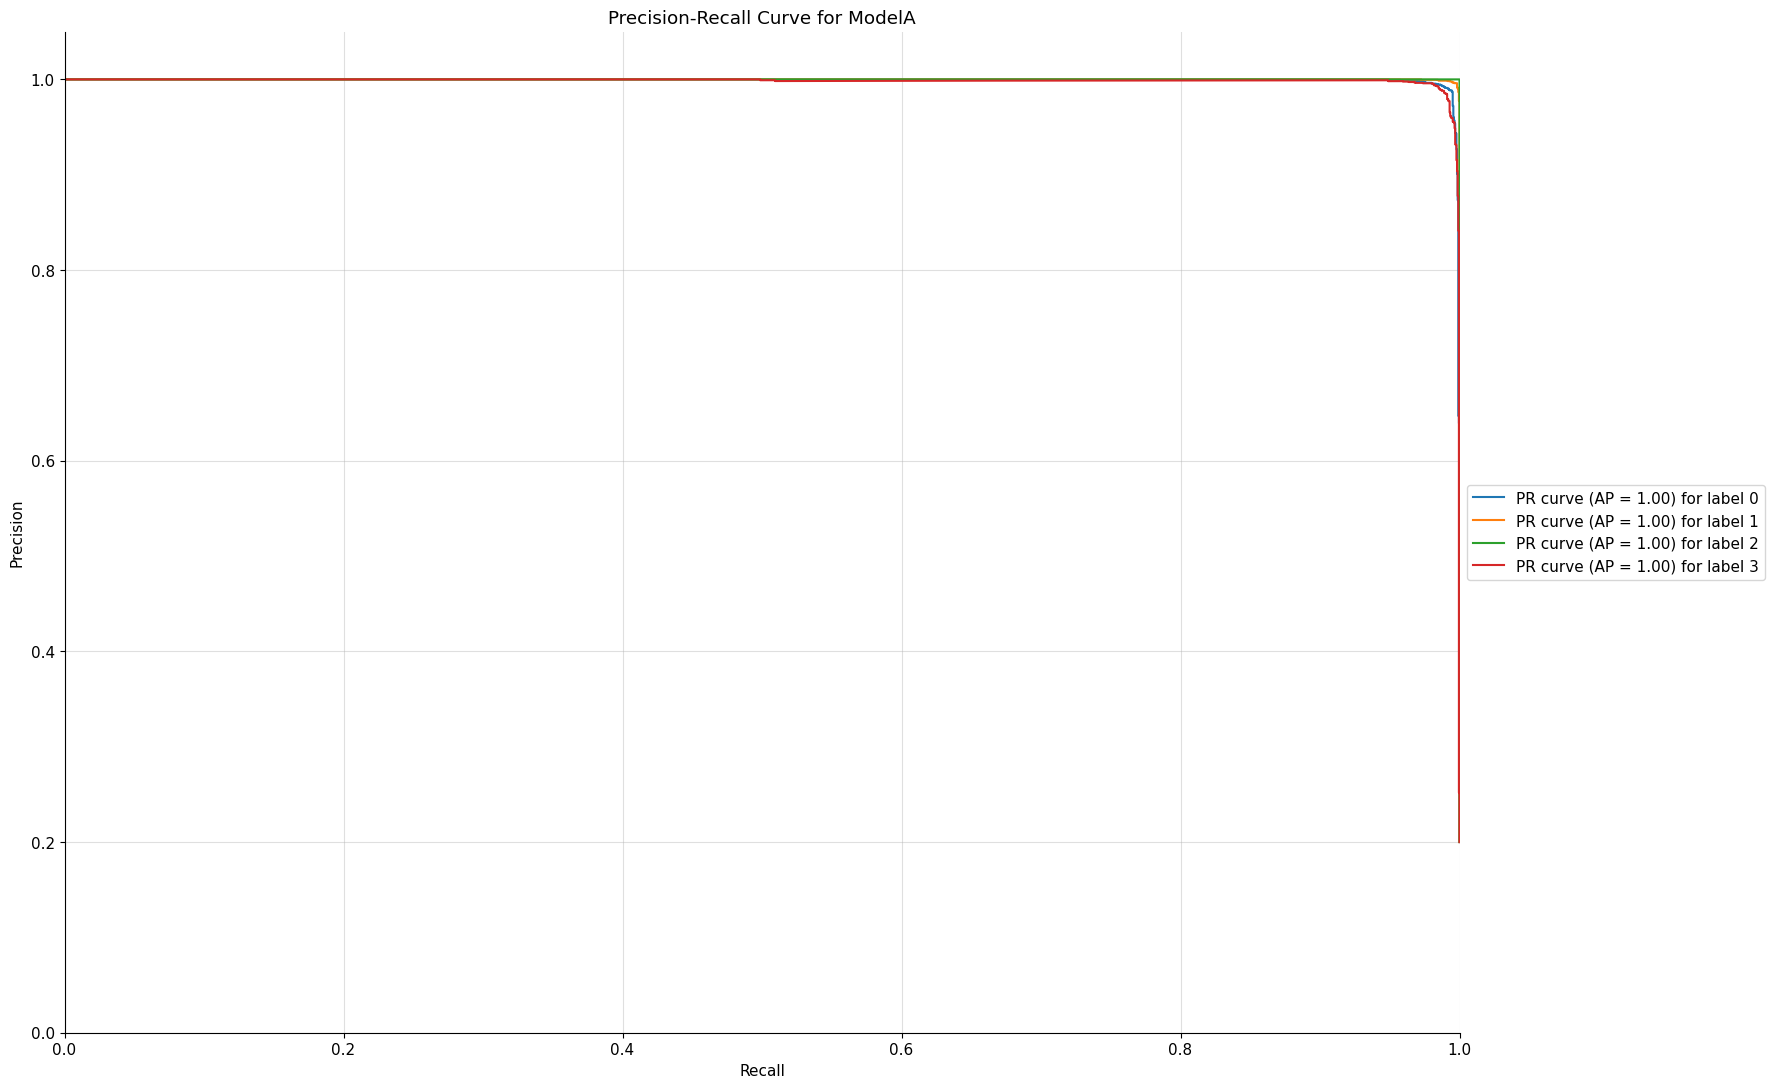

In [39]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_curve(ensemble_model, test_generator, model_name):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)

    # 初始化 Precision 和 Recall 字典
    precision = dict()
    recall = dict()
    average_precision = dict()

    # 计算每个类别的 Precision 和 Recall
    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    # 绘制 Precision-Recall 曲线
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {model_name}')

    for i in range(4):
        ax.plot(recall[i], precision[i], label='PR curve (AP = %0.2f) for label %i' % (average_precision[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_precision_recall_curve(ensemble_model, test_generator, 'ModelA')

In [40]:
ensemble_model.save('rice_model.h1')

INFO:tensorflow:Assets written to: rice_model.h1/assets


INFO:tensorflow:Assets written to: rice_model.h1/assets
